# Cooling System of a FSAE Car


In [810]:
# If you want the figures to appear in the notebook, 
# and you want to interact with them, use
# %matplotlib notebook

# If you want the figures to appear in the notebook, 
# and you don't want to interact with them, use
# %matplotlib inline

# If you want the figures to appear in separate windows, use
# %matplotlib qt5

# tempo switch from one to another, you have to select Kernel->Restart

%matplotlib inline

from modsim import *
import math

### The coffee cooling problem.

I'll use a `State` object to store the initial temperature.


In [558]:
init= State(tempMotor=90 , tempCooling = 80)
init

,value
tempMotor,90
tempCooling,80


And a `System` object to contain the system parameters.

In [794]:
motor = System(init = init, 
                u = 9000, #heat generated by motor
                p = .994, #density,
                v = 8, #volume
                c = 4178, #specific heat capacity
                dt = 1, #time step
                Tm = 70, #temperature of motor
               # A = 1232, #area of surface in m^2
                h = 1000, #convection coefficient
                T_end = 600
                )
motor

,value
init,tempMotor 90 tempCooling 80 dtype: int64
u,9000
p,0.994
v,8
c,4178
dt,1
Tm,70
h,1000
T_end,600


In [795]:
cooling = System(init = init, 
                p = 1.097, #density,
                v = 119.034, #volume
                c = 1007, #specific heat capacity
                dt = 1, #time steps
                Tc = 50, #temperature of coolin system,
                #A = 1232, #area of surface in in^2
                T_env = 40,
                h = 1000,
                T_end = 600 
                )

cooling

,value
init,tempMotor 90 tempCooling 80 dtype: int64
p,1.097
v,119.034
c,1007
dt,1
Tc,50
T_env,40
h,1000
T_end,600


The `update` function implements Newton's law of cooling.

In [796]:
def updateCooling(state, system1, system2):
    unpack(system2)
    Tc = state.tempCooling
    Tc += (-h * (Tc - T_env) + system1.h*(system1.Tm - Tc)) / (p * v * c) * dt
    
    State(tempCooling = Tc)
    return Tc

In [797]:
def updateMotor(state, system1, system2):
    """Update the thermal transfer model.
    
    state: State (temp)
    system: System object
    
    returns: State (temp)
    """
    unpack(system1)
    T = state.tempMotor
    T += (-h * (T - system2.Tc) - u)/(p * v * c) * dt

    return State(tempMotor = T)

In [798]:
def updateTemp(state, system1, system2):
    """Update the thermal transfer model.
    
    state: State (temp)
    system: System object
    
    returns: State (temp)
    """
    unpack(system1)
    Tm = state.tempMotor
    Tm += (-h * (Tm - system2.Tc) + u)/(p * v * c) * dt

    system2.Tc = state.tempCooling
    system2.Tc += (-system2.h * (system2.Tc - system2.T_env) + h*(Tm - system2.Tc)) / (system2.p * system2.v * system2.c) * system2.dt
    
    return State(tempMotor = Tm, tempCooling = system2.Tc)

print(init)

tempMotor      90
tempCooling    80
dtype: int64


Here's how it works.

In [799]:
updateMotor(init, motor, cooling)

,value
tempMotor,88.525138


In [800]:
updateTemp(init, motor, cooling)

,value
tempMotor,89.066924
tempCooling,79.764757


In [801]:
print(updateCooling(init, motor, cooling))

79.6197555548


Now we can run simulations using the same function from the previous chapter.

In [802]:
def run_simulation(system1, system2, update_func1, update_func2):
    """Runs a simulation of the system.
    
    Add a TimeFrame to the System: results
    
    system: System object
    update_func: function that updates state
    """
    unpack(system1)
    
    frame = TimeFrame(columns=init.index)
    frame.loc[Tm] = init.tempMotor

    ts = linrange(Tm, T_end, dt)
    
    for t in ts:
        frame.loc[t+dt] = updateTemp(frame.loc[t], system1, system2)
    
    system1.results = frame
    system2.results = frame

And here's how it works.

In [803]:
run_simulation(motor, cooling, updateMotor, updateCooling)
motor.results.loc[600]

tempMotor      60.054239
tempCooling    50.656199
Name: 600, dtype: float64

Here's what the results look like.

In [804]:
def run_simulation_cooling(system, updateCooling):
    unpack(system)
    
    frame = TimeFrame(columns=init.index)
    frame.loc[Tc] = init.tempCooling
    ts = linrange(Tc, T_end, dt)
    
    for t in ts:
        frame.loc[t+dt] = updateCooling(frame.loc[t], motor, cooling)
    
    system.results = frame

In [805]:
#run_simulation_cooling(cooling, updateCooling)
#cooling.results.loc[600]

After running the simulation, we can extract the final temperature from the results.

C:\ProgramData\Miniconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


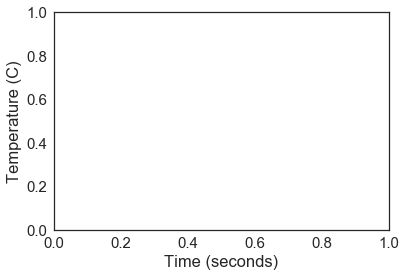

In [806]:
#plot(cooling.results.tempCooling, label='cooling')
decorate(xlabel='Time (seconds)',
         ylabel='Temperature (C)')

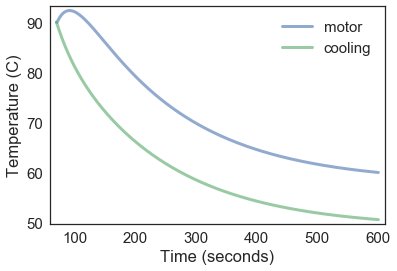

In [807]:
plot(motor.results.tempMotor, label='motor')
plot(cooling.results.tempCooling, label= 'cooling')
decorate(xlabel='Time (seconds)',
         ylabel='Temperature (C)')

In [814]:
(math.pi) * (math.pi)

9.869604401089358

It will be convenient to wrap these steps in a function.  `kwargs` is a collection of whatever keyword arguments are provided; they are passed along as arguments to `System`.

In [721]:
def make_system(T_init=90, r=0.01, volume=300, t_end=30):
    """Runs a simulation with the given parameters.

    T_init: initial temperature in degC
    r: heat transfer rate, in 1/min
    volume: volume of liquid in mL
    t_end: end time of simulation
    
    returns: System object
    """
    init = State(temp=T_init)
    
    system = System(init=init,
                    volume=volume,
                    r=r,
                    T_env=22, 
                    t0=0,
                    t_end=t_end,
                    dt=1)
    return system

Here's how we use it:

In [263]:
coffee = make_system()
run_simulation(coffee, update)
final_temp(coffee)

NameError: name 'update' is not defined

**Exercise:**  Simulate the temperature of 50 mL of milk with a starting temperature of 5 degC, in a vessel with the same insulation, for 15 minutes, and plot the results.

In [16]:
milk = make_system(T_init = 5, r= 0.01, volume = 50, t_end = 15)
run_simulation(milk, update)
final_temp(milk)


7.3790079710980949

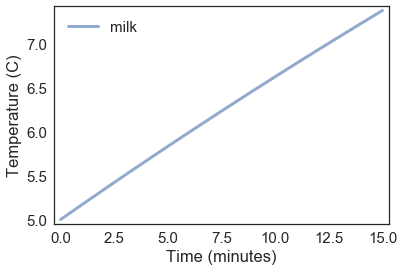

In [17]:
plot(milk.results.temp, label='milk')
decorate(xlabel='Time (minutes)',
         ylabel='Temperature (C)')

### Using `fsolve`

As a simple example, let's find the roots of this function; that is, the values of `x` that make the result 0.

In [18]:
def func(x):
    return (x-1) * (x-2) * (x-3)

`modsim.py` provides `fsolve`, which does some error-checking and then runs `scipy.optimize.fsolve`.  The first argument is the function whose roots we want.  The second argument is an initial guess.

In [19]:
fsolve(func, x0=0)

array([ 1.])

Usually the root we get is the one that's closest to the initial guess.

In [20]:
fsolve(func, 1.9)

array([ 2.])

In [21]:
fsolve(func, 2.9)

array([ 3.])

But not always.

In [22]:
fsolve(func, 1.5)

array([ 3.])

We want to find the value of `r` that makes the final temperature 70, so we define an "error function" that takes `r` as a parameter and returns the difference between the final temperature and the goal.

In [26]:
def error_func1(r):
    """Runs a simulation and returns the `error`.
    
    r: heat transfer rate, in 1/min
    
    returns: difference between final temp and 70 C
    """
    system = make_system(r=r)
    run_simulation(system, update)
    print('running error_func1')
    return final_temp(system) - 70

With `r=0.01`, we end up a little too warm.

In [27]:
error_func1(r=0.01)

running error_func1


2.2996253904030937

The return value from `fsolve` is an array with a single element, the estimated value of `r`.

In [28]:
solution = fsolve(error_func1, 0.01, xtol=1e-8)
r_coffee = solution[0]
r_coffee

running error_func1
running error_func1
running error_func1
running error_func1
running error_func1
running error_func1
running error_func1
running error_func1
running error_func1
running error_func1


0.011543084583978345

If we run the simulation with the estimated value of `r`, the final temperature is 70 C, as expected.

In [29]:
coffee = make_system(r=r_coffee)
run_simulation(coffee, update)
final_temp(coffee)

70.0

**Exercise:**  When you call `fsolve`, it calls `error_func1` several times.  To see how this works, add a print statement to `error_func1` and run `fsolve` again.

**Exercise:** Repeat this process to estimate `r_milk`, given that it starts at 5 C and reaches 20 C after 15 minutes.  

Before you use `fsolve`, you might want to try a few values for `r_milk` and see how close you can get by trial and error.  Here's an initial guess to get you started:

In [56]:
r_milk = 0.133
milk = make_system(T_init=5, t_end=15, r=r_milk)
run_simulation(milk, update)
final_temp(milk)

20.001356278974139

In [58]:
def error_func1(r):
    """Runs a simulation and returns the `error`.
    
    r: heat transfer rate, in 1/min
    
    returns: difference between final temp and 70 C
    """
    system = make_system(r=r,T_init=5, t_end=15)
    run_simulation(system, update)
    print('running error_func1')
    return final_temp(system) - 20

In [59]:
solution = fsolve(error_func1, .133, xtol = 1e-8)
r_milk = solution[0]
r_milk

running error_func1
running error_func1
running error_func1
running error_func1
running error_func1
running error_func1
running error_func1
running error_func1


0.13296078935466457

In [61]:
error_func1(0.13296078935466457)

running error_func1


0.0

### Mixing liquids

The following function takes `System` objects that represent two liquids, computes the temperature of the mixture, and returns a new `System` object that represents the mixture.

In [62]:
def mix(s1, s2):
    """Simulates the mixture of two liquids.
    
    s1: System representing coffee
    s2: System representing milk
    
    returns: System representing the mixture
    """
    assert s1.t_end == s2.t_end
    
    volume = s1.volume + s2.volume
    
    temp = (s1.volume * final_temp(s1) + 
            s2.volume * final_temp(s2)) / volume
    
    mixture = make_system(T_init=temp,
                          volume=volume,
                          r=s1.r)
    
    return mixture

First we'll see what happens if we add the milk at the end.  We'll simulate the coffee and the milk separately.

In [63]:
coffee = make_system(T_init=90, t_end=30, r=r_coffee, volume=300)
run_simulation(coffee, update)
final_temp(coffee)

70.0

In [64]:
milk = make_system(T_init=5, t_end=30, r=r_milk, volume=50)
run_simulation(milk, update)
final_temp(milk)

21.764705882352942

Here's what the results look like.

Saving figure to file chap07-fig01.pdf


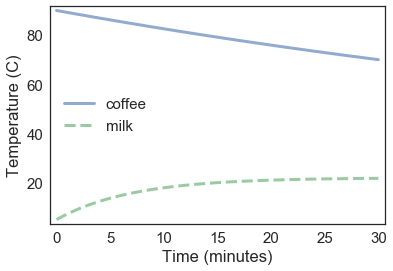

In [65]:
plot(coffee.results.temp, label='coffee')
plot(milk.results.temp, '--', label='milk')
decorate(xlabel='Time (minutes)',
         ylabel='Temperature (C)',
         loc='center left')

savefig('chap07-fig01.pdf')

Here's what happens when we mix them.

In [66]:
mix_last = mix(coffee, milk)
final_temp(mix_last)

63.109243697478988

And here's what we get if we add the milk immediately.

In [67]:
coffee = make_system(T_init=90, r=r_coffee, volume=300)
milk = make_system(T_init=5, r=r_milk, volume=50)

In [68]:
mix_first = mix(coffee, milk)
mix_first.t_end = 30
run_simulation(mix_first, update)
final_temp(mix_first)

61.428571428571438

The following function takes `t_add`, which is the time when the milk is added, and returns the final temperature.

In [69]:
def run_and_mix(t_add, t_total=30):
    """Simulates two liquids and them mixes them at t_add.
    
    t_add: time in minutes
    t_total: total time to simulate, min
    
    returns: final temperature
    """
    coffee = make_system(T_init=90, t_end=t_add, 
                         r=r_coffee, volume=300)
    run_simulation(coffee, update)

    milk = make_system(T_init=5, t_end=t_add, 
                       r=r_milk, volume=50)
    run_simulation(milk, update)
    
    mixture = mix(coffee, milk)
    mixture.t_end = t_total - t_add
    run_simulation(mixture, update)

    return final_temp(mixture)

We can try it out with a few values.

In [70]:
run_and_mix(0)

61.428571428571438

In [71]:
run_and_mix(15)

62.90280912845234

In [72]:
run_and_mix(30)

63.109243697478988

And then sweep a range of values for `t_add`

In [73]:
sweep = SweepSeries()
for t_add in linrange(0, 30, 2):
    temp = run_and_mix(t_add)
    sweep[t_add] = temp

Here's what the result looks like.

Saving figure to file chap07-fig02.pdf


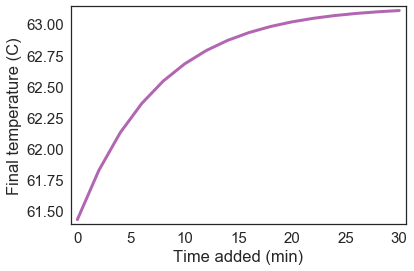

In [74]:
plot(sweep, color='purple')
decorate(xlabel='Time added (min)',
         ylabel='Final temperature (C)',
         legend=False)

savefig('chap07-fig02.pdf')

**Exercise:**  Suppose the coffee shop won't let me take milk in a separate container, but I keep a bottle of milk in the refrigerator at my office.  In that case is it better to add the milk at the coffee shop, or wait until I get to the office?

Hint: Think about the simplest way to represent the behavior of a refrigerator in this model.  The change you make to test this variation of the problem should be very small!

In [110]:
def update1(state, system):
    """Update the thermal transfer model.
    
    state: State (temp)
    system: System object
    
    returns: State (temp)
    """
    unpack(system)
    T = state.temp

    return State(temp=T)

In [111]:
coffee = make_system(T_init=90, t_end=30, r=r_coffee, volume=300)
run_simulation(coffee, update)
final_temp(coffee)

70.0

In [112]:
fridgeMilk = make_system(T_init=5, r=r_milk, volume=50, t_end=30)
run_simulation(fridgeMilk, update1)
final_temp(fridgeMilk)

5.0

In [113]:
mix_last1 = mix(coffee, fridgeMilk)
final_temp(mix_last1)

60.714285714285715

In [115]:
print('it is better to add milk at the coffee shop bc it is', final_temp(mix_first) - final_temp(mix_last1), 'degrees hotter than adding it at the office')

it is better to add milk at the coffee shop bc it is 0.714285714286 degrees hotter than adding it at the office


### Analysis

Now we can use the analytic result to compute temperature as a function of time.  The following function is similar to `run_simulation`.

In [75]:
def run_analysis(system):
    """Computes temperature using the analytic solution.
    
    Adds TimeFrame to `system` as `results`
    
    system: System object
    """
    unpack(system)
    
    T_init = init.temp    
    ts = linrange(t0, t_end, dt)
    
    temp_array = T_env + (T_init - T_env) * exp(-r * ts)
    temp_series = TimeSeries(temp_array, index=ts)
    
    system.results = TimeFrame(temp_series, columns=['temp'])

Here's how we run it.  From the analysis, we have the computed value of `r_coffee2`

In [76]:
r_coffee2 = 0.011610223142273859

In [77]:
init = State(temp=90)
coffee2 = System(init=init, T_env=22, r=r_coffee2, 
                 t0=0, t_end=30)
run_analysis(coffee2)
final_temp(coffee2)

70.0

And we can compare to the results from simulation.

In [78]:
init = State(temp=90)
coffee = System(init=init, T_env=22, r=r_coffee, 
                t0=0, t_end=30, dt=1)
run_simulation(coffee, update)
final_temp(coffee)

70.0

They are identical except for small roundoff errors.

In [79]:
coffee.results - coffee2.results

,temp
0,0.000000e+00
1,0.000000e+00
2,0.000000e+00
3,0.000000e+00
4,0.000000e+00
5,0.000000e+00
6,0.000000e+00
7,0.000000e+00
8,0.000000e+00
9,0.000000e+00
